<a href="https://colab.research.google.com/github/JCaballerot/Deep_learning_program/blob/main/Topicos_avanzados/Oxford_IIIT_Pet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><font size="5">Oxford-IIIT Pet</font></h1>



Este dataset está diseñado específicamente para tareas de clasificación de imágenes y detección de objetos relacionadas con mascotas.


---
*  Contiene alrededor de 7,400 imágenes de 37 categorías diferentes de mascotas, con un enfoque en razas de perros y gatos.

---



<center>
  <img src="https://production-media.paperswithcode.com/datasets/Oxford-IIIT_Pets-0000000571-4547798f_WG4TMz3.jpg" width="800" height="300">
</center>


Este notebook proporciona un ejemplo práctico de cómo cargar, preprocesar y modelar el dataset Oxford-IIIT Pet para tareas de clasificación de imágenes utilizando TensorFlow. Este dataset es un conjunto de datos estándar en el dominio del aprendizaje profundo para la clasificación de imágenes de mascotas, con un enfoque particular en diferentes razas de perros y gatos.



### 1. Instalación de dependencias


Primero, nos aseguramos de tener todas las dependencias necesarias instaladas. Esto incluye TensorFlow y TensorFlow Datasets.

In [15]:
%%capture
!pip install tensorflow-datasets

### 2. Principales librerías

Antes de comenzar, importamos las bibliotecas necesarias. TensorFlow se usa para construir y entrenar el modelo, TensorFlow Datasets para cargar el dataset y Matplotlib para la visualización.

In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### 3. Carga del dataset Oxford-IIIT Pet

El dataset se carga utilizando TensorFlow Datasets, lo que simplifica el proceso de descargar y preparar los datos. Al cargar el dataset, también obtenemos info que contiene metadatos útiles sobre el dataset, como el número de clases y ejemplos.



In [17]:
# Carga el conjunto de datos Oxford-IIIT Pet, descargándolo si es necesario
ds, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, split='train', as_supervised=True)

# Información del conjunto de datos
print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

### 3. Preparación de datos

Para una exploración inicial, seleccionamos una muestra de 1000 imágenes. Esto nos permite trabajar con un conjunto de datos más pequeño, facilitando el proceso de desarrollo y prueba del modelo.

In [ ]:

# Para trabajar con una muestra más pequeña, puedes usar la operación take
sample_ds = ds.take(2000)  # Toma solo las primeras 100 imágenes

# Iterar sobre la muestra del conjunto de datos
for image, label in sample_ds:
    print(image.shape, label)

Iteramos a través de esta muestra para inspeccionar las dimensiones de las imágenes y sus correspondientes etiquetas.

El preprocesamiento es un paso crucial para asegurar que las imágenes estén en el formato adecuado para entrenar nuestro modelo. Redimensionamos las imágenes a 128x128 y normalizamos los valores de los píxeles a un rango de 0 a 1.

In [19]:

def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0  # Normalizar a [0, 1]
    return image, label

# Cargar el conjunto de datos
(ds_train, ds_test), ds_info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
)

# Preprocesar el conjunto de datos
ds_train = ds_train.take(500).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.take(500).map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

Cargamos y dividimos el dataset en conjuntos de entrenamiento y prueba, aplicando la función de preprocesamiento a cada imagen.



### 4. Arquitectura de la red

Nuestro modelo utiliza una arquitectura convolucional simple con capas de convolución y max pooling, seguida por capas densas para la clasificación final. La última capa tiene una unidad por cada clase en el dataset y utiliza la función de activación softmax.



1. Capa convolucional: 32 filtros de tamaño 3x3, activación ReLU.
2. Pooling: Max pooling con una ventana de 2x2.
3. Capa convolucional: 64 filtros de tamaño 3x3, activación ReLU.
4. Pooling: Max pooling con una ventana de 2x2.
5. Flatten: Aplana la salida para convertirla en un vector.
6. Densa: Capa densa con 128 unidades, activación ReLU.
7. Salida: Capa densa con un número de unidades igual al número de clases en el dataset, activación softmax.

In [20]:
from tensorflow.keras.regularizers import l1

In [23]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer = l1(0.05)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = l1(0.05)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = l1(0.05)),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 61, 61, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                 

Compilamos el modelo especificando el optimizador, la función de pérdida y las métricas. Luego, entrenamos el modelo con los datos de entrenamiento, utilizando los datos de prueba para la validación.



In [24]:
history = model.fit(ds_train, validation_data=ds_test, epochs=10)


Epoch 1/10
16/16 [==============================] - 23s 1s/step - loss: 704.4144 - accuracy: 0.0160 - val_loss: 297.1986 - val_accuracy: 0.0180
Epoch 2/10
16/16 [==============================] - 22s 1s/step - loss: 182.6383 - accuracy: 0.0300 - val_loss: 116.7851 - val_accuracy: 0.0280
Epoch 3/10
16/16 [==============================] - 22s 1s/step - loss: 91.2117 - accuracy: 0.0280 - val_loss: 70.2250 - val_accuracy: 0.0140
Epoch 4/10
16/16 [==============================] - 22s 1s/step - loss: 63.3609 - accuracy: 0.0560 - val_loss: 58.5106 - val_accuracy: 0.0140
Epoch 5/10
16/16 [==============================] - 22s 1s/step - loss: 54.2018 - accuracy: 0.0440 - val_loss: 50.9465 - val_accuracy: 0.0140
Epoch 6/10
16/16 [==============================] - 21s 1s/step - loss: 51.3638 - accuracy: 0.0440 - val_loss: 51.2114 - val_accuracy: 0.0140
Epoch 7/10
16/16 [==============================] - 21s 1s/step - loss: 50.3989 - accuracy: 0.0440 - val_loss: 49.9445 - val_accuracy: 0.0140
Ep

### 5. Evaluación y predicción



Para evaluar la efectividad de nuestro modelo, realizamos predicciones sobre nuevas imágenes del conjunto de prueba y comparamos los resultados con las etiquetas reales. Esto nos proporciona una buena indicación de cómo el modelo podría comportarse en datos no vistos previamente.


1/1 [==============================] - 0s 191ms/step


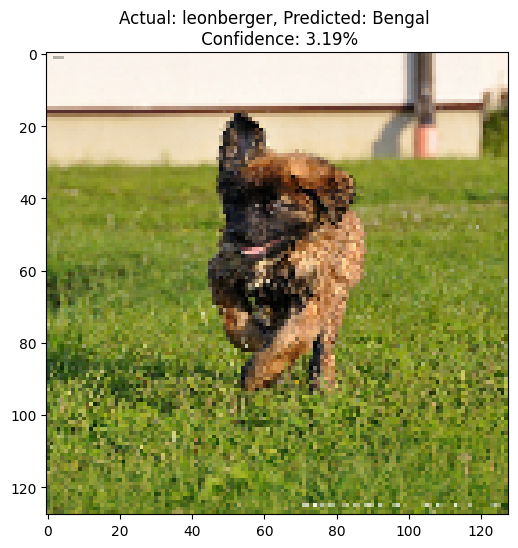

1/1 [==============================] - 0s 33ms/step


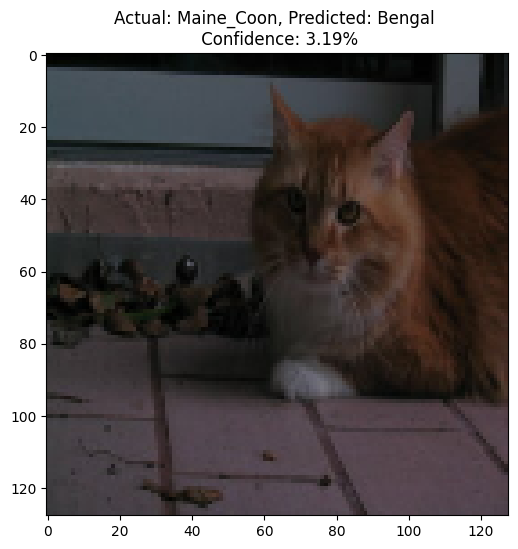

1/1 [==============================] - 0s 26ms/step


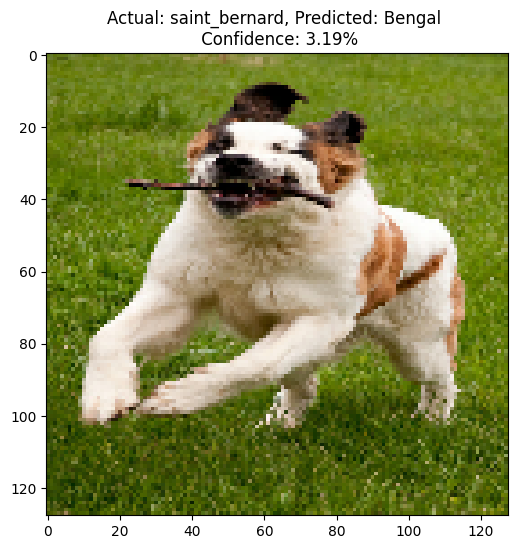

1/1 [==============================] - 0s 24ms/step


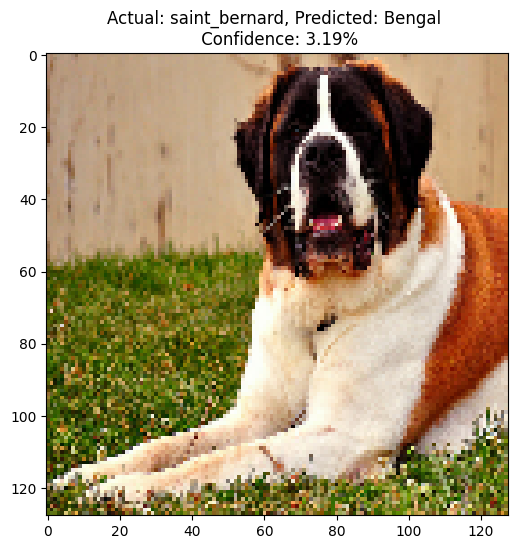

1/1 [==============================] - 0s 31ms/step


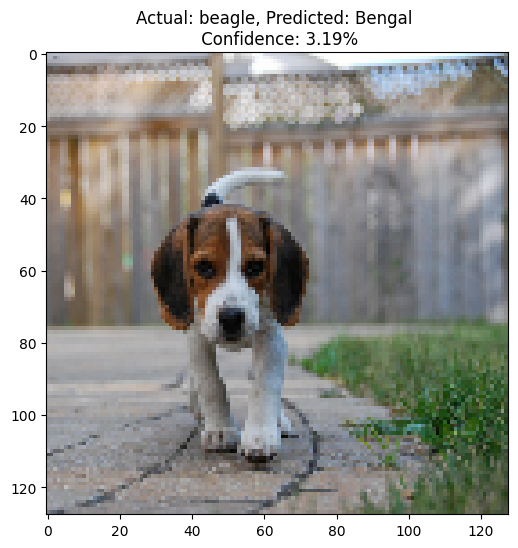

1/1 [==============================] - 0s 25ms/step


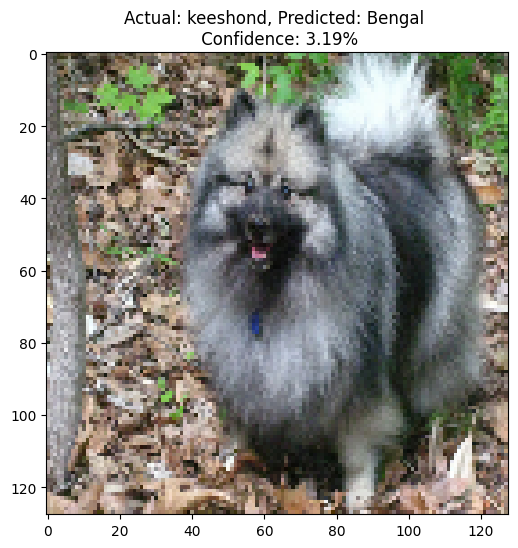

1/1 [==============================] - 0s 27ms/step


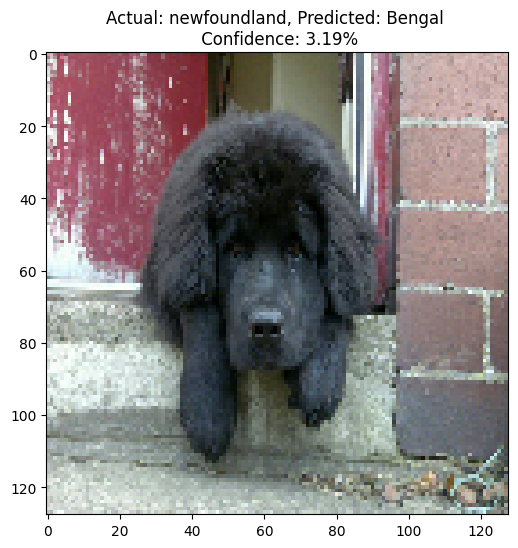

1/1 [==============================] - 0s 29ms/step


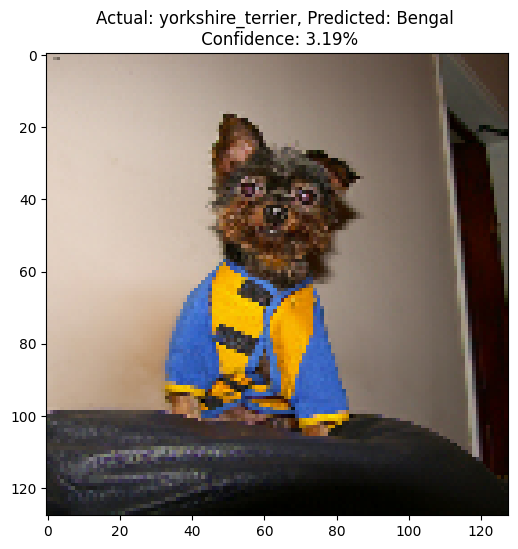

1/1 [==============================] - 0s 25ms/step


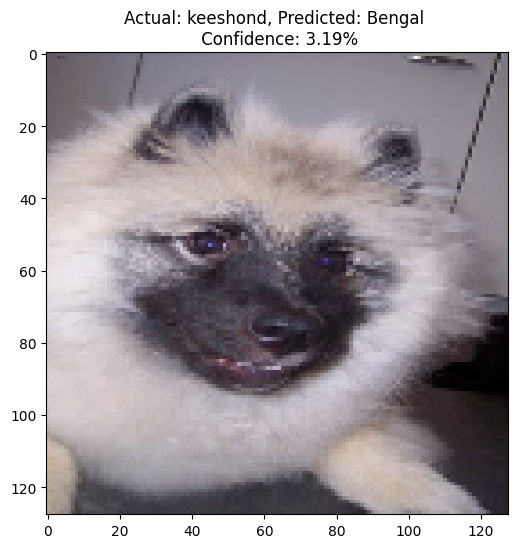

1/1 [==============================] - 0s 25ms/step


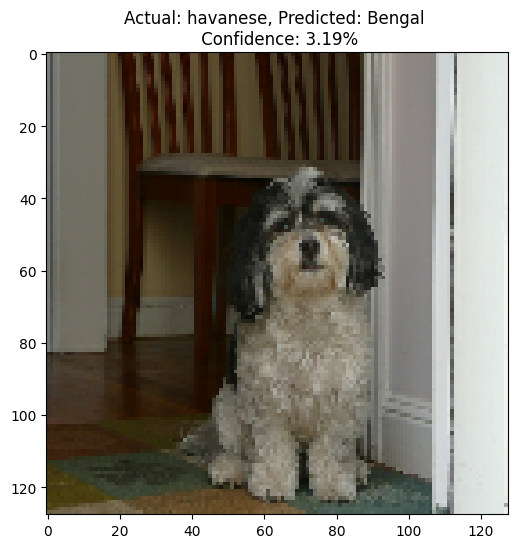

1/1 [==============================] - 0s 26ms/step


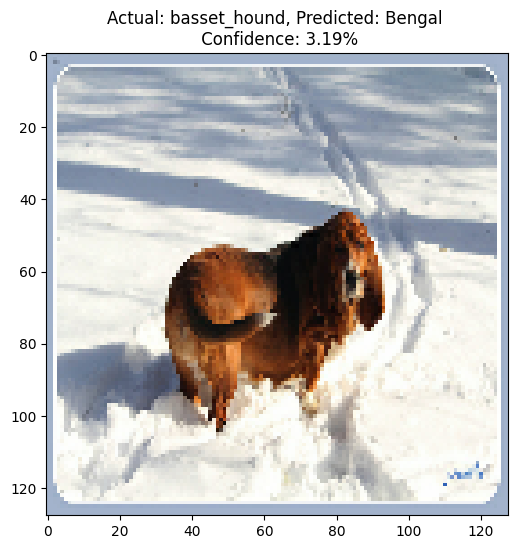

1/1 [==============================] - 0s 41ms/step


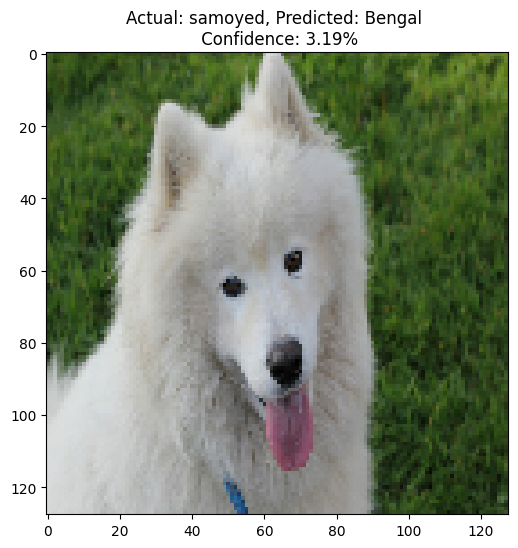

1/1 [==============================] - 0s 37ms/step


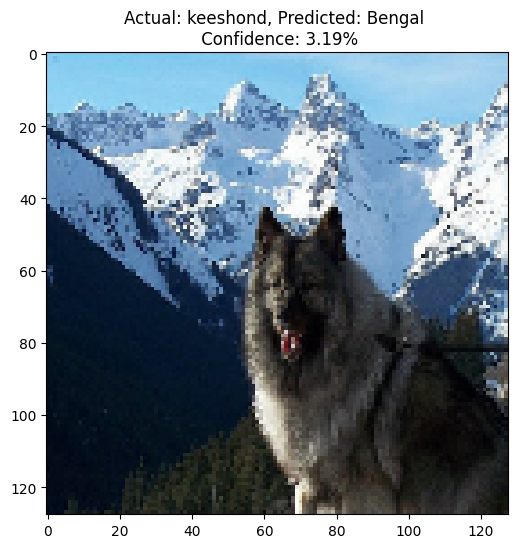

1/1 [==============================] - 0s 39ms/step


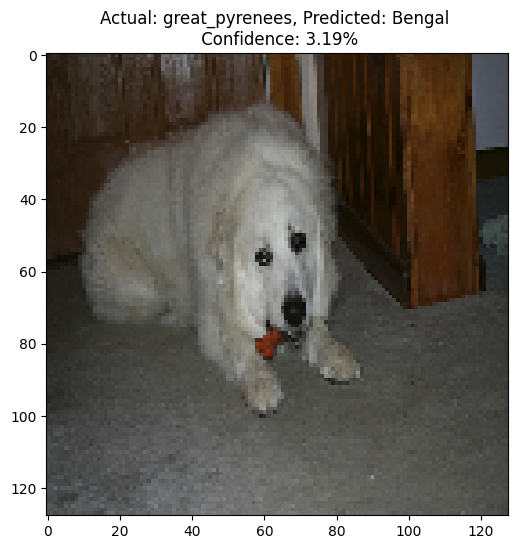

1/1 [==============================] - 0s 38ms/step


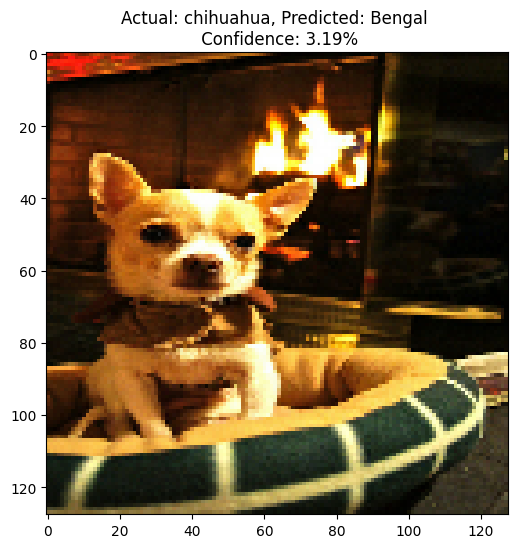

1/1 [==============================] - 0s 38ms/step


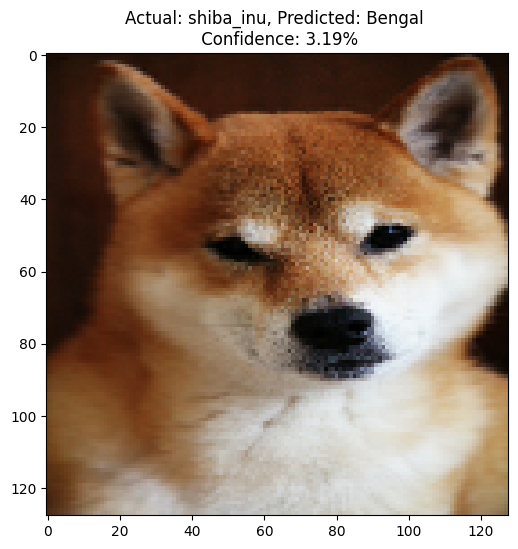

1/1 [==============================] - 0s 39ms/step


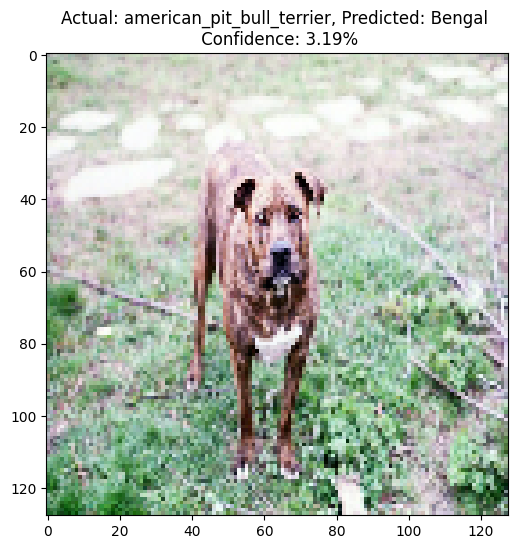

1/1 [==============================] - 0s 60ms/step


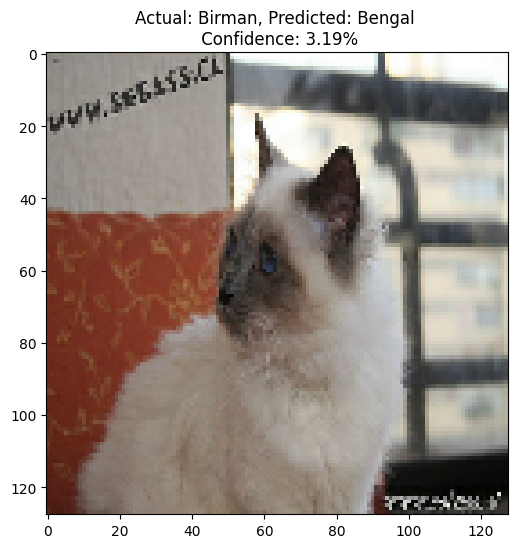

1/1 [==============================] - 0s 75ms/step


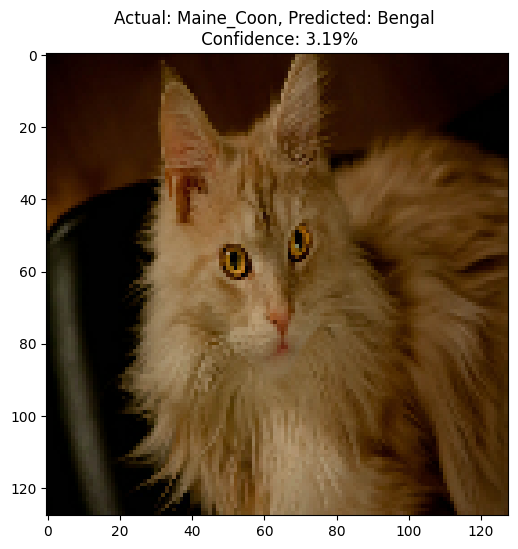

1/1 [==============================] - 0s 86ms/step


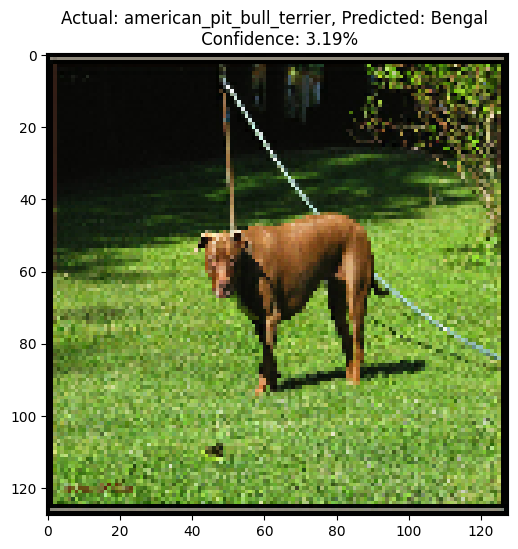

1/1 [==============================] - 0s 56ms/step


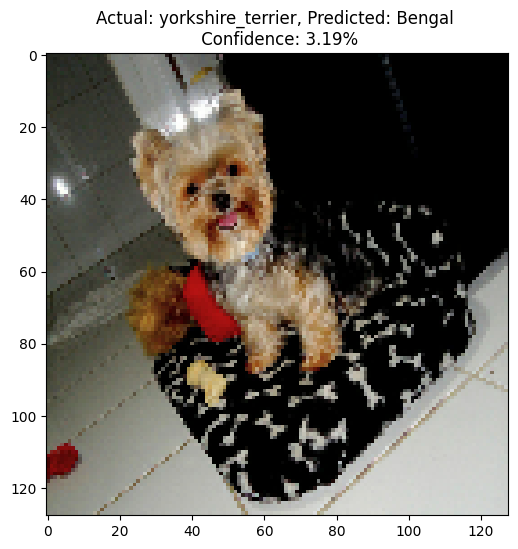

1/1 [==============================] - 0s 47ms/step


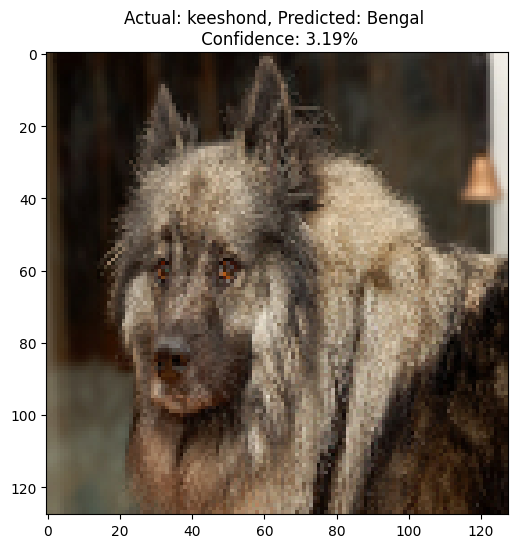

1/1 [==============================] - 0s 39ms/step


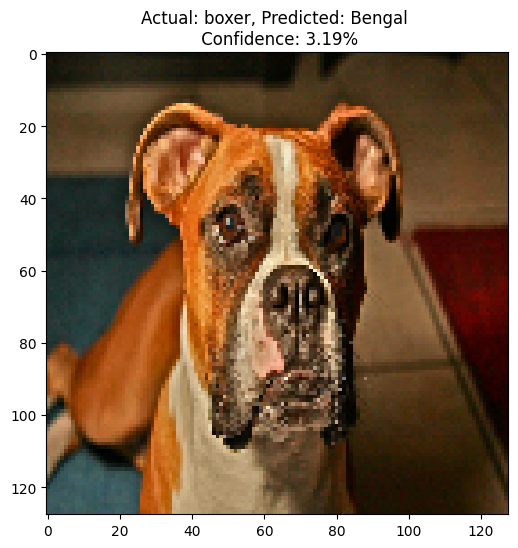

1/1 [==============================] - 0s 82ms/step


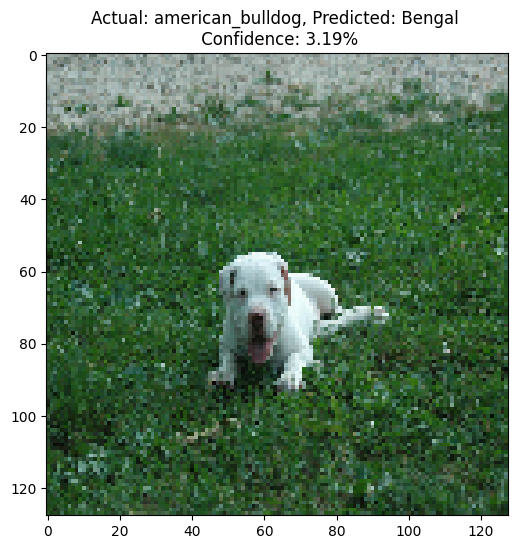

1/1 [==============================] - 0s 28ms/step


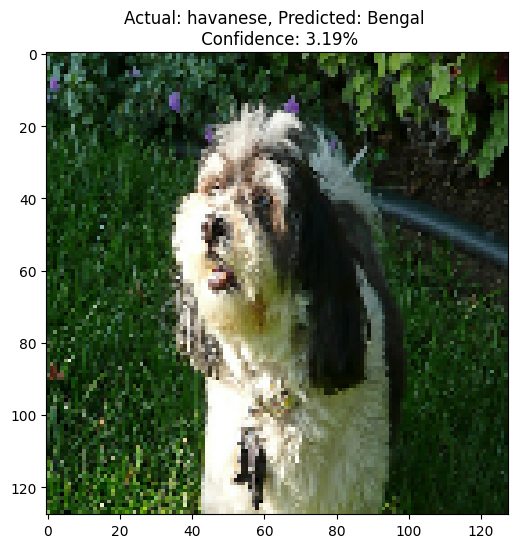

1/1 [==============================] - 0s 27ms/step


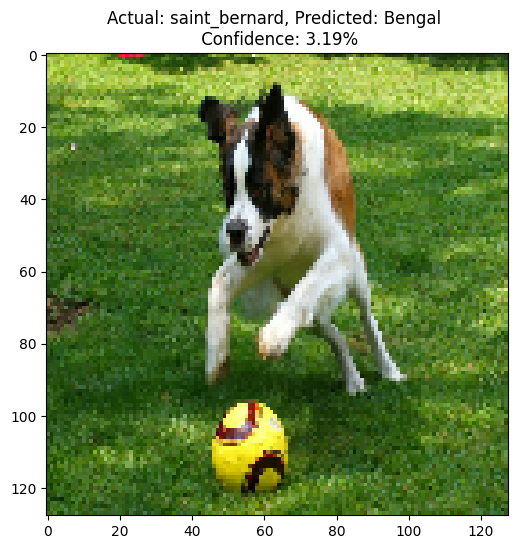

1/1 [==============================] - 0s 25ms/step


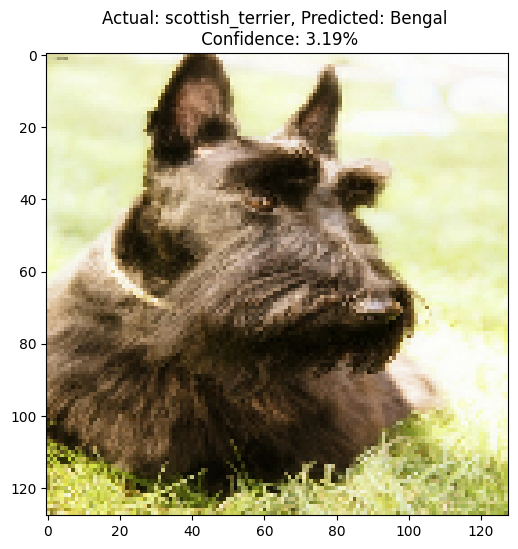

1/1 [==============================] - 0s 33ms/step


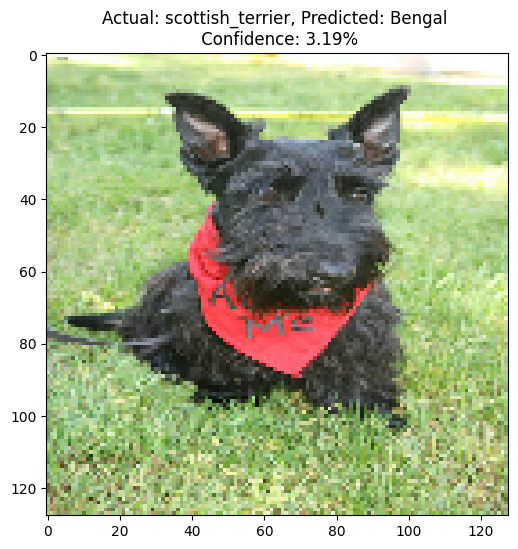

1/1 [==============================] - 0s 25ms/step


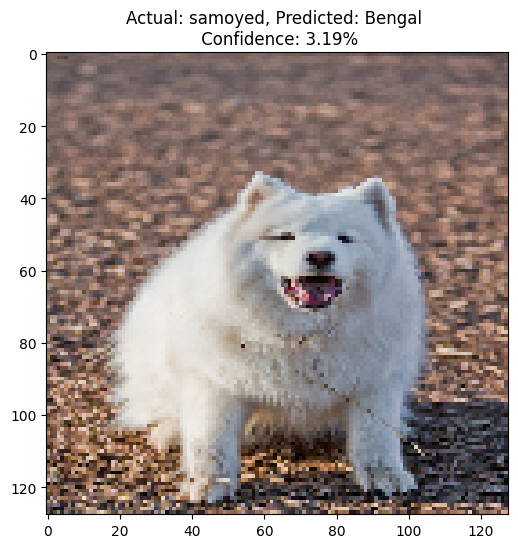

1/1 [==============================] - 0s 26ms/step


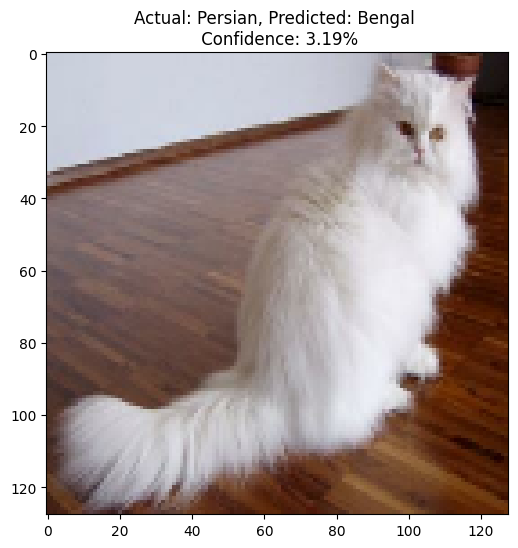

In [25]:
import numpy as np

# Asumiendo que `model` es tu modelo entrenado y `ds_test` es tu conjunto de datos de prueba preprocesado

# Tomar una sola imagen y etiqueta del conjunto de datos de prueba
for image, true_label in ds_test.unbatch().take(30):
    # Expandir las dimensiones de la imagen para que sea `(1, height, width, channels)`
    img_array = tf.expand_dims(image, 0)

    # Realizar la predicción
    predictions = model.predict(img_array)

    # Tomar la clase predicha y la confianza (probabilidad)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    # Obtener la etiqueta de clase real y predicha para mostrar
    class_names = ds_info.features['label'].names
    true_label_name = class_names[true_label]
    predicted_class_name = class_names[predicted_class]

    # Mostrar la imagen, la clase predicha y la confianza
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'Actual: {true_label_name}, Predicted: {predicted_class_name} \n Confidence: {confidence*100:.2f}%')
    plt.show()

In [26]:
loss, accuracy = model.evaluate(ds_test)
print(f'Total accuracy: {accuracy*100:.2f}%')

16/16 [==============================] - 4s 241ms/step - loss: 49.9303 - accuracy: 0.0140
Total accuracy: 1.40%


In [27]:
loss, accuracy = model.evaluate(ds_train)
print(f'Total accuracy: {accuracy*100:.2f}%')

16/16 [==============================] - 5s 299ms/step - loss: 49.9025 - accuracy: 0.0440
Total accuracy: 4.40%


### 6. Experimentación con una arquitectura alternativa (Alexnet)

Como paso adicional, experimentamos con una arquitectura de modelo inspirada en AlexNet, adaptada para nuestro problema específico. Esto ilustra cómo diferentes arquitecturas pueden influir en el rendimiento del modelo.

In [ ]:
alexnet_like_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')
])

alexnet_like_model.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

alexnet_like_model.summary()

Este laboratorio demuestra el proceso completo de cargar, preparar y entrenar un modelo de clasificación de imágenes utilizando el conjunto de datos Oxford-IIIT Pet.  La arquitectura del modelo se basa en capas convolucionales y de pooling para extraer características, y capas densas para la clasificación. Se entrenan dos modelos diferentes, uno siguiendo una estructura secuencial básica y otro inspirado en AlexNet, mostrando la flexibilidad y el poder de TensorFlow para el manejo y análisis de imágenes.

---
## Gracias por completar este laboratorio!